In [151]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [152]:
df = pd.read_csv("Cornescu_Darius_new_features.csv")
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,SalePrice,LotArea_m^2,Price_per_m^2,ZoningScore,SubClassScore,LotAreaNorm,PDI,Price_per_m^2_norm,EVI
0,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,145000,780.385200,185.805676,0.795605,0.105263,0.033186,0.359777,0.168856,0.344162
1,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,178000,728.080811,244.478356,0.795605,0.315789,0.030555,0.422145,0.226847,0.415263
2,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,85000,815.409631,104.242085,0.795605,0.157895,0.034948,0.376095,0.088239,0.314380
3,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,175000,668.901600,261.622935,0.795605,0.263158,0.027577,0.405462,0.243793,0.413210
4,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,127000,464.515000,273.403442,0.795605,0.263158,0.017294,0.402378,0.255437,0.419031


In [153]:
def make_preprocessor(dataframe):
    numeric_features = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = dataframe.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
    ])

    return preprocessor

In [154]:
def run_classification_pipeline(dataframe, number_bins, labels = None, random_state=42):
    
    target = "SalePrice"
    prices = dataframe[target].copy()

    if labels is None:
        labels = list(range(number_bins))

    Y = pd.qcut(prices, q=number_bins, labels=labels)
    X = dataframe.drop(columns=[target])

    preprocessor = make_preprocessor(X)
    classifier = DecisionTreeClassifier(random_state=random_state)

    Pipeline_steps = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, stratify=Y)

    Pipeline_steps.fit(X_train, Y_train)
    Y_pred = Pipeline_steps.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    report = classification_report(Y_test, Y_pred)
    cm = confusion_matrix(Y_test, Y_pred, labels = classifier.classes_)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", report)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(cmap=plt.cm.Blues)

    return Pipeline_steps

Accuracy: 0.905982905982906
F1 Score: 0.9061779098469381
Classification Report:
               precision    recall  f1-score   support

       cheap       0.93      0.95      0.94        79
   expensive       0.95      0.90      0.92        78
      medium       0.85      0.87      0.86        77

    accuracy                           0.91       234
   macro avg       0.91      0.91      0.91       234
weighted avg       0.91      0.91      0.91       234



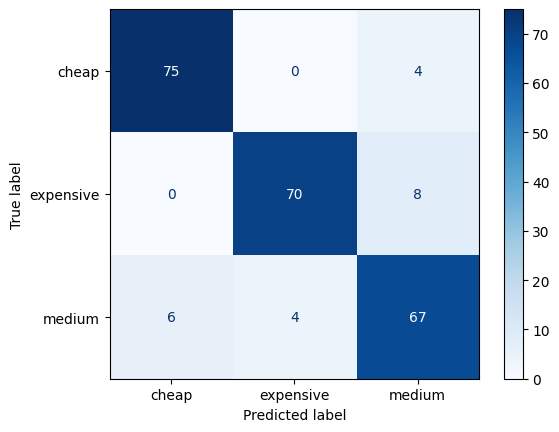

In [155]:
labels_3 = ["cheap", "medium", "expensive"]
res_3 = run_classification_pipeline(df, number_bins=3, labels=labels_3)

Accuracy: 0.5214
F1 Score: 0.5221

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.64        22
           1       0.40      0.29      0.33        21
           2       0.52      0.52      0.52        21
           3       0.48      0.68      0.57        22
           4       0.41      0.43      0.42        21
           5       0.27      0.33      0.30        21
           6       0.35      0.33      0.34        21
           7       0.53      0.45      0.49        22
           8       0.59      0.62      0.60        21
           9       0.85      0.52      0.65        21
          10       0.90      0.86      0.88        21

    accuracy                           0.52       234
   macro avg       0.54      0.52      0.52       234
weighted avg       0.54      0.52      0.52       234



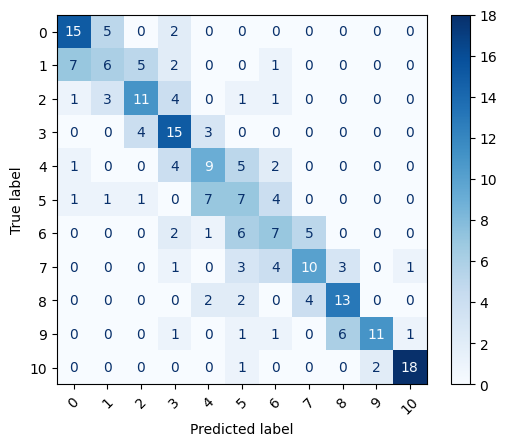

In [178]:
k_opt = 11
res_k = run_classification_pipeline(df, number_bins=k_opt)

In [157]:
def analyze_price_distribution(dataframe, bin_width=None):
    prices = dataframe["SalePrice"]
    min_price = prices.min()
    max_price = prices.max()

    bins = np.arange(min_price, max_price + bin_width, bin_width)
    price_groups = pd.cut(prices, bins=bins)
    distribution = price_groups.value_counts().sort_index()

    print(f"Min Price: ${min_price:,.0f}")
    print(f"Max Price: ${max_price:,.0f}")
    print(f"\nDistribuție pe intervale de ${bin_width:,}:")
    with pd.option_context('display.max_rows', None):
        print(distribution)
    
    return distribution
    

In [158]:
print("\n" + "=" * 80)
print("ANALIZĂ CU INTERVALE DE $100,000")
print("=" * 80)
dist_100k = analyze_price_distribution(df, bin_width=100000)


ANALIZĂ CU INTERVALE DE $100,000
Min Price: $34,900
Max Price: $745,000

Distribuție pe intervale de $100,000:
SalePrice
(34900, 134900]     325
(134900, 234900]    624
(234900, 334900]    162
(334900, 434900]     44
(434900, 534900]      7
(534900, 634900]      4
(634900, 734900]      0
(734900, 834900]      1
Name: count, dtype: int64


In [159]:
print("\n" + "=" * 80)
print("ANALIZĂ CU INTERVALE DE $50,000")
print("=" * 80)
dist_50k = analyze_price_distribution(df, bin_width=50000)


ANALIZĂ CU INTERVALE DE $50,000
Min Price: $34,900
Max Price: $745,000

Distribuție pe intervale de $50,000:
SalePrice
(34900, 84900]       40
(84900, 134900]     285
(134900, 184900]    407
(184900, 234900]    217
(234900, 284900]    112
(284900, 334900]     50
(334900, 384900]     27
(384900, 434900]     17
(434900, 484900]      5
(484900, 534900]      2
(534900, 584900]      3
(584900, 634900]      1
(634900, 684900]      0
(684900, 734900]      0
(734900, 784900]      1
Name: count, dtype: int64


In [160]:
print("\n" + "=" * 80)
print("ANALIZĂ CU INTERVALE DE $20,000")
print("=" * 80)
dist_20k = analyze_price_distribution(df, bin_width=20000)


ANALIZĂ CU INTERVALE DE $20,000
Min Price: $34,900
Max Price: $745,000

Distribuție pe intervale de $20,000:
SalePrice
(34900, 54900]        4
(54900, 74900]        9
(74900, 94900]       60
(94900, 114900]      89
(114900, 134900]    163
(134900, 154900]    178
(154900, 174900]    150
(174900, 194900]    145
(194900, 214900]     77
(214900, 234900]     74
(234900, 254900]     54
(254900, 274900]     42
(274900, 294900]     28
(294900, 314900]     15
(314900, 334900]     23
(334900, 354900]     14
(354900, 374900]      6
(374900, 394900]     14
(394900, 414900]      5
(414900, 434900]      5
(434900, 454900]      3
(454900, 474900]      1
(474900, 494900]      2
(494900, 514900]      1
(514900, 534900]      0
(534900, 554900]      1
(554900, 574900]      1
(574900, 594900]      1
(594900, 614900]      0
(614900, 634900]      1
(634900, 654900]      0
(654900, 674900]      0
(674900, 694900]      0
(694900, 714900]      0
(714900, 734900]      0
(734900, 754900]      1
Name: count, dty

In [161]:
print("\n" + "=" * 80)
print("ANALIZĂ CU INTERVALE DE $10,000")
print("=" * 80)
dist_10k = analyze_price_distribution(df, bin_width=10000)


ANALIZĂ CU INTERVALE DE $10,000
Min Price: $34,900
Max Price: $745,000

Distribuție pe intervale de $10,000:
SalePrice
(34900, 44900]        2
(44900, 54900]        2
(54900, 64900]        7
(64900, 74900]        2
(74900, 84900]       27
(84900, 94900]       33
(94900, 104900]      30
(104900, 114900]     59
(114900, 124900]     68
(124900, 134900]     95
(134900, 144900]    103
(144900, 154900]     75
(154900, 164900]     77
(164900, 174900]     73
(174900, 184900]     79
(184900, 194900]     66
(194900, 204900]     39
(204900, 214900]     38
(214900, 224900]     37
(224900, 234900]     37
(234900, 244900]     34
(244900, 254900]     20
(254900, 264900]     21
(264900, 274900]     21
(274900, 284900]     16
(284900, 294900]     12
(294900, 304900]      7
(304900, 314900]      8
(314900, 324900]     14
(324900, 334900]      9
(334900, 344900]      9
(344900, 354900]      5
(354900, 364900]      2
(364900, 374900]      4
(374900, 384900]      7
(384900, 394900]      7
(394900, 404900]

In [162]:
print("=" * 80)
print("ANALIZĂ CU INTERVALE DE $5,000")
print("=" * 80)
dist_5k = analyze_price_distribution(df, bin_width=5000)

ANALIZĂ CU INTERVALE DE $5,000
Min Price: $34,900
Max Price: $745,000

Distribuție pe intervale de $5,000:
SalePrice
(34900, 39900]       2
(39900, 44900]       0
(44900, 49900]       0
(49900, 54900]       2
(54900, 59900]       3
(59900, 64900]       4
(64900, 69900]       0
(69900, 74900]       2
(74900, 79900]       8
(79900, 84900]      19
(84900, 89900]      18
(89900, 94900]      15
(94900, 99900]      14
(99900, 104900]     16
(104900, 109900]    29
(109900, 114900]    30
(114900, 119900]    37
(119900, 124900]    31
(124900, 129900]    53
(129900, 134900]    42
(134900, 139900]    52
(139900, 144900]    51
(144900, 149900]    47
(149900, 154900]    28
(154900, 159900]    40
(159900, 164900]    37
(164900, 169900]    36
(169900, 174900]    37
(174900, 179900]    49
(179900, 184900]    30
(184900, 189900]    33
(189900, 194900]    33
(194900, 199900]    16
(199900, 204900]    23
(204900, 209900]    18
(209900, 214900]    20
(214900, 219900]    18
(219900, 224900]    19
(224900, 

In [237]:
def analyze_qcut_distribution(dataframe, n_bins):
    prices = dataframe['SalePrice']
    price_categories = pd.qcut(prices, q=n_bins, duplicates='drop')

    distribution = price_categories.value_counts().sort_index()
    print(f"\nDistribuție:")
    with pd.option_context('display.max_rows', None):
        print(distribution)
    
    return price_categories, distribution


cats, dist = analyze_qcut_distribution(df, 10)



Distribuție:
SalePrice
(34899.999, 107000.0]    118
(107000.0, 125000.0]     123
(125000.0, 137000.0]     111
(137000.0, 149000.0]     116
(149000.0, 165000.0]     120
(165000.0, 179900.0]     115
(179900.0, 200000.0]     120
(200000.0, 230000.0]     115
(230000.0, 275950.0]     113
(275950.0, 745000.0]     117
Name: count, dtype: int64


In [239]:
def create_smart_bins(dataframe):
    """
        very_cheap --- 34.9K - 90K  
        cheap --- 90K - 120K
        affordable --- 120K - 140K 
        medium_low --- 140K - 160K 
        medium --- 160K - 180K 
        medium_high --- 180K - 200K 
        expensive --- 200K - 235K
        very_expensive --- 235K - 285K 
        luxury --- 285K - 400K 
        ultra_luxury --- 400K+ 

    """
    prices = dataframe['SalePrice']
    custom_bins = [
        34900,  
        90000,      
        120000,     
        140000,     
        160000,    
        180000,     
        200000,     
        235000,     
        285000,     
        400000,     
        745001     
    ]

    labels = ['very_cheap', 'cheap', 'affordable', 'medium_low', 'medium', 'medium_high', 'expensive', 'very_expensive', 'luxury', 'ultra_luxury']

    price_groups = pd.cut(prices, bins=custom_bins, labels=labels, include_lowest=True)
    distribution = price_groups.value_counts().sort_index()
    

    print("\nIntervale și count-uri:")
    for i, (label, count) in enumerate(zip(labels, distribution)):
        print(f"{label:20s} [{custom_bins[i]:>8,.0f} - {custom_bins[i+1]:>8,.0f}]: {count:4d} case")
    
    return custom_bins, labels

custom_bins, custom_labels = create_smart_bins(df)


Intervale și count-uri:
very_cheap           [  34,900 -   90,000]:   62 case
cheap                [  90,000 -  120,000]:  144 case
affordable           [ 120,000 -  140,000]:  188 case
medium_low           [ 140,000 -  160,000]:  161 case
medium               [ 160,000 -  180,000]:  156 case
medium_high          [ 180,000 -  200,000]:  112 case
expensive            [ 200,000 -  235,000]:  134 case
very_expensive       [ 235,000 -  285,000]:  107 case
luxury               [ 285,000 -  400,000]:   83 case
ultra_luxury         [ 400,000 -  745,001]:   21 case


Accuracy: 0.6880
F1 Score: 0.6882

Classification Report:
                precision    recall  f1-score   support

    affordable       0.71      0.76      0.73        38
         cheap       0.77      0.79      0.78        29
     expensive       0.76      0.59      0.67        27
        luxury       0.69      0.65      0.67        17
        medium       0.66      0.68      0.67        31
   medium_high       0.72      0.57      0.63        23
    medium_low       0.61      0.62      0.62        32
  ultra_luxury       0.75      0.75      0.75         4
    very_cheap       0.90      0.75      0.82        12
very_expensive       0.55      0.76      0.64        21

      accuracy                           0.69       234
     macro avg       0.71      0.69      0.70       234
  weighted avg       0.70      0.69      0.69       234



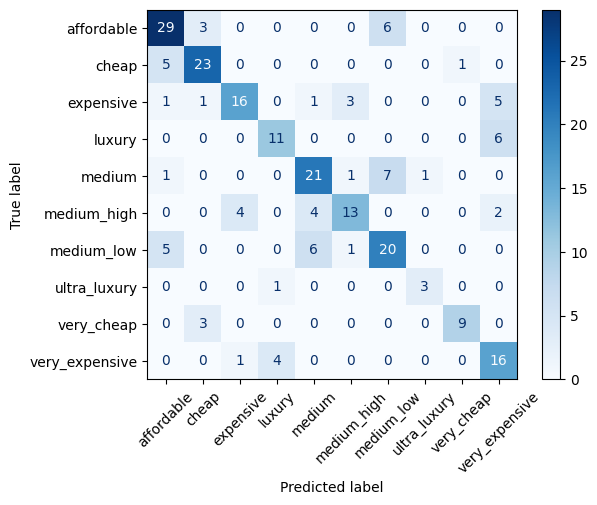

In [241]:
def run_classification_pipeline(dataframe, number_bins=None, labels=None, custom_bins=None, random_state=42):
    
    target = "SalePrice"
    prices = dataframe[target].copy()

    if custom_bins is not None:
        Y = pd.cut(prices, bins=custom_bins, labels=labels, include_lowest=True)
    elif number_bins is not None:
        if labels is None:
            labels = list(range(number_bins))
        Y = pd.qcut(prices, q=number_bins, labels=labels, duplicates='drop')

    X = dataframe.drop(columns=[target])
    preprocessor = make_preprocessor(X)
    classifier = DecisionTreeClassifier(random_state=random_state)

    Pipeline_steps = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, stratify=Y)

    Pipeline_steps.fit(X_train, Y_train)
    Y_pred = Pipeline_steps.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    report = classification_report(Y_test, Y_pred)
    cm = confusion_matrix(Y_test, Y_pred, labels=classifier.classes_)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"\nClassification Report:\n{report}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

    return Pipeline_steps


res_custom = run_classification_pipeline(df, custom_bins=custom_bins, labels=custom_labels)

Performanța a crescut de la 0,52 la 0,64, o îmbunătățire semnificativă, dar unele intervale rămân problematice. Limitele sunt foarte sensibile: de exemplu, pentru medium_low, ajustarea capetelor ca să reduc confuzia cu medium și affordable îmbunătățește local rezultatele, dar strică alte clase. Cea mai bună modificare a fost la very_cheap: mutarea limitei superioare de la 80k la 90k a ridicat scorul de la 0,64 la 0,688.


Am testat multiple ajustări ale valorilor, dar nu am găsit o configurație care să îmbunătățească acuratețea.